In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import os
import itertools
import pickle

temp = os.getcwd()
print(f'Current working directory: {temp}')
if '/project2' in temp:
    temp = temp.replace('/project2', '')
    os.chdir(temp)
    print(f'Switched to: {temp}')

Current working directory: /Users/marco/dev/time-series/project2
Switched to: /Users/marco/dev/time-series


In [4]:
def import_stocks(name):
    df = pd.read_excel('data/'+str(name)+'.xlsx', header=3, index_col='Date')
    df = df.reindex(index=df.index[::-1])           # Go from old to new, instead of new to old
    df.index = pd.to_datetime(df.index)
    return df

def calc_log_returns(df):
    df['Log-Close'] = np.log(df['Close'])
    df['Log-Return'] = df['Log-Close'].diff()
    return 

names = ['EDP RENOVAVEISprice', 'GALP ENERGIA-NOMprice', 'MOTA ENGILprice', 'NOSSGPSprice', 'NOVABASESGPSprice']

edp = import_stocks(names[0])
edp.name = 'EDP'
galp = import_stocks(names[1])
galp.name = 'GALP'
mota = import_stocks(names[2])
mota.name = 'MOTA'
noss = import_stocks(names[3])
noss.name = 'NOSS'
nova = import_stocks(names[4])
nova.name = 'NOVA'

stock_list = [edp, galp, mota, noss, nova]

for stock_df in stock_list:
    calc_log_returns(stock_df)                                      # Add new column with log return                     
    stock_df.drop(index=stock_df.index[0], axis=0, inplace=True)    # Drop first row, because no log return 

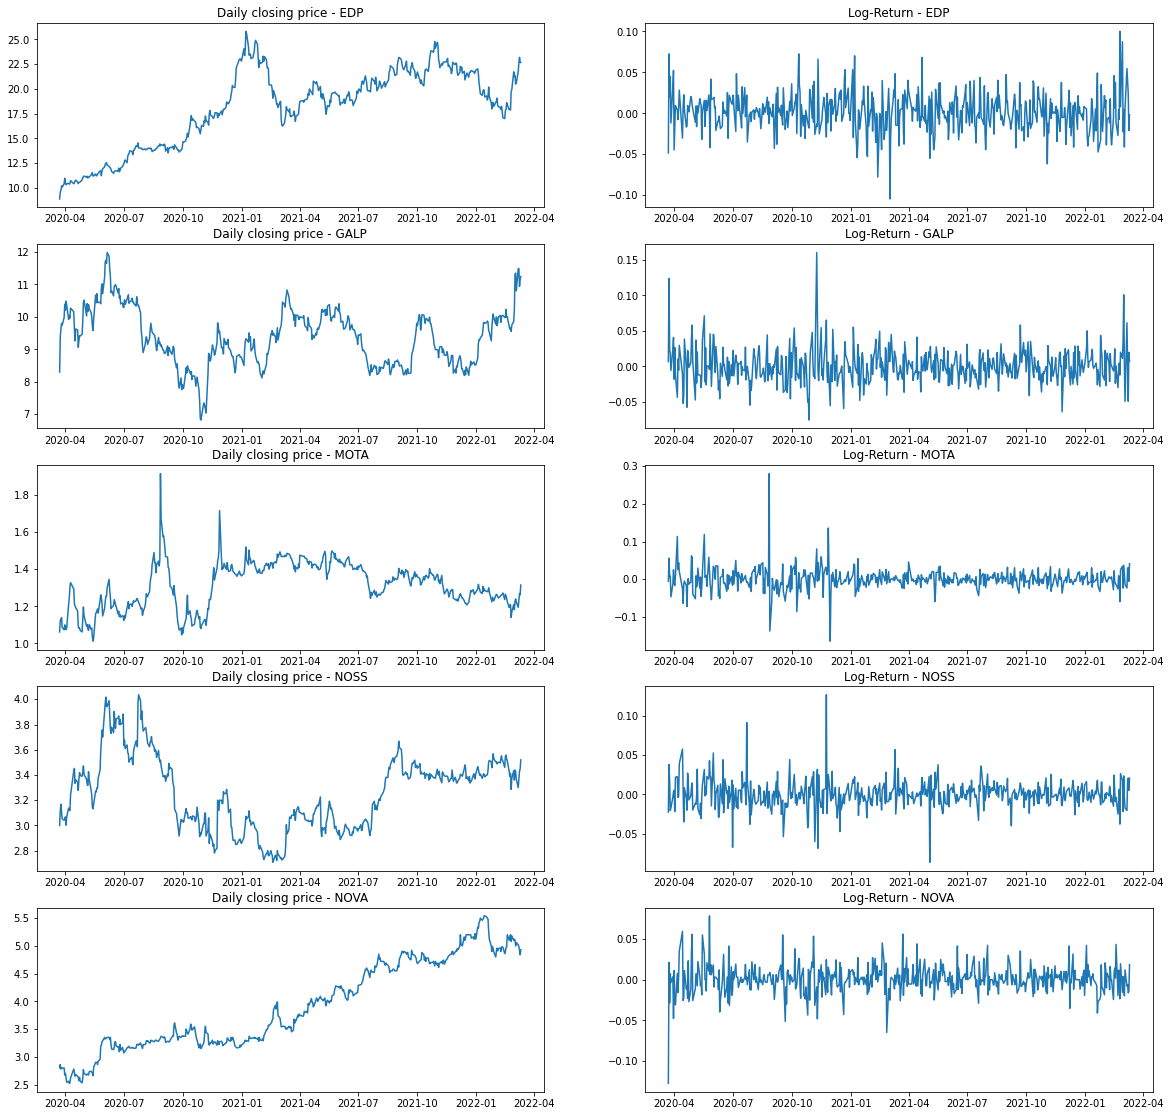

In [20]:
#plt.plot(edp['Log-Return'])
#plt.show()

#fig = plt.figure(figsize=(10,10))
plt.figure(figsize=(20,40))
for idx, stock in enumerate(stock_list):
    plt.subplot(10, 2, 2*idx+1)
    plt.plot(stock.Close)
    plt.gca().set_title(f'Daily closing price - {stock.name}')
    plt.subplot(10, 2, 2*idx+2)
    plt.plot(stock['Log-Return'])
    plt.gca().set_title(f'Log-Return - {stock.name}')
    
plt.show()


/Users/marco/anaconda3/envs/ts/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


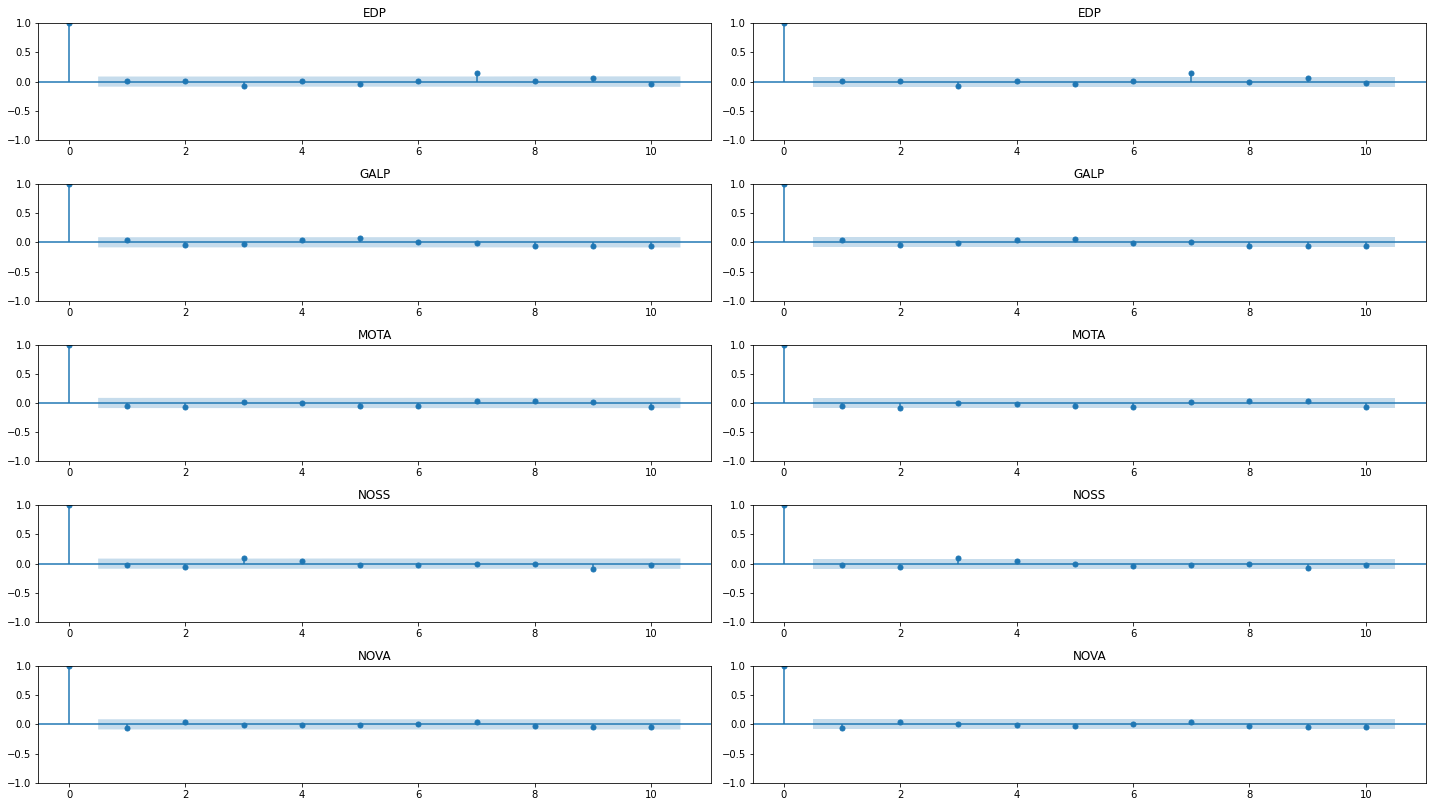

In [21]:
fig = plt.figure(figsize=(20,20))

for idx, stock in enumerate(stock_list):
    plot_acf(stock['Log-Return'], lags=10, title=f'ACF for Log-Return - {stock.name}', ax=plt.subplot(9, 2, idx*2+1))
    plot_pacf(stock['Log-Return'], lags=10, title=f'PACF for Log-Return - {stock.name}', ax=plt.subplot(9, 2, idx*2+2))

fig.tight_layout()
plt.show()

In [74]:
p_list = list(range(1, 10))
q_list = list(range(1, 10))
tmp = os.getcwd()

for stock in stock_list:
    model_dict = {}
    file = os.path.join(tmp, f'models/proj2/{stock.name}.pkl')
    if not os.path.isfile(file):
        for p,q in itertools.product(p_list, q_list):
            model = arch_model(stock['Log-Return'], mean='Zero', vol='GARCH', p=p, q=q, rescale=True)
            model_fit = model.fit(disp=False)
            model_dict[f'{p},{q}'] = (model_fit.bic, model_fit)
        model_dict['best'] = min(model_dict, key=lambda key: model_dict[key][0])
    try:
        with open(file, 'ab') as f:
            pickle.dump(model_dict, f, pickle.HIGHEST_PROTOCOL)
    except:
        print('Error while trying to save dict. Exiting')
        break
else:
    print(f'Already exists: {file}')




Already exists: /Users/marco/dev/time-series/models/proj2/NOVA.pkl


In [76]:
best_key = model_dict['best']
best_model = model_dict[best_key][1]
print(best_model.std_resid.mean(), best_model.std_resid.var())

print(best_key)
print(model_dict[best_key][1])


0.07124092822729769 1.0097242147472698
1,1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log-Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -968.437
Distribution:                  Normal   AIC:                           1942.87
Method:            Maximum Likelihood   BIC:                           1955.56
                                        No. Observations:                  507
Date:                Thu, Jun 16 2022   Df Residuals:                      507
Time:                        15:41:49   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       